In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime as dt
import os
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import scipy.stats as stats
import math
import random
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions

In [2]:
# Importing the Dataset
file_names = glob.glob ('./EthernetData/dataset2.csv')
k = 0

# Change these two variables to get different results
#degree change
n = 1
#operating state
op_state = 'Heating'
exclude_state = 'Cooling'

# Given millisecond utc timestamp return time
def tz_from_utc_ms_ts(utc_ms_ts):
    
    # convert from time stamp to datetime
    utc_datetime = dt.datetime.utcfromtimestamp(utc_ms_ts / 1000.)
    
    # getting time from datetime object
    res = utc_datetime.hour + utc_datetime.minute / 60
    if res - 5 < 0:
        res = 24 + (res - 5)
    else:
        res = res - 5
    return res

# Visualising the result as time of day vs cooling time of machine
def plot (time_difference, y, temp_change):
    fig = plt.figure (k)
    ax = plt.subplot ()
    plt.bar (y, time_difference, 0.05, align = 'center', alpha = 1)
    plt.xlabel ('Time of day')
    plt.ylabel ('Time taken for ' + op_state + ' ' + str (temp_change) + ' Degree (in Minutes)')
    ax.set_xticks ([0,5,10,15,20,24])
    ax.set_xticklabels (['00:00', '05:00', '10:00', '15:00', '20:00', '00:00'])
    plt.title (os.path.basename (path))
    plt.show ()
    pp.savefig (fig)
    plt.close (fig)

In [3]:
# Finding time required for temparature change...
import json
data = [[],[],[],[]]

def time_to_change_temperature (X, temp_change):
    # Time to cool one degree in minutes
    time_difference = []
    # Factor represts temparature change between cooling/heating on and off.
    factor = 1
    y = []
    curr_temp = 0
    i = 0
    avg_time_to_change = 0
    while i < len(X):

        content = json.loads (X.content[i])
        if 'status' in content and "room_temp" in content["status"]:
            curr_temp = content["status"]["room_temp"]
        
        if 'status' in content and "operating_state" in content["status"] and content["status"]["operating_state"] in [op_state] :
            curr_index = i
            
            hh = tz_from_utc_ms_ts(X.created_date_time[i])
            while i < len(X):
                content = json.loads (X.content[i])
                if 'status' in content and "room_temp" in content["status"]:
                    if(op_state == "Cooling"):
                        factor = curr_temp - content["status"]["room_temp"]
                    else:
                        factor =  content["status"]["room_temp"] - curr_temp
                    
                    if( factor == temp_change):
#                         print(i+1, curr_temp, content["status"]["room_temp"])
                        diff = abs((X.created_date_time[i] - X.created_date_time[curr_index])/(60000))
                        time_difference.append (diff)
                        avg_time_to_change = avg_time_to_change + (diff)
                        y.append(hh)
                        data[temp_change - 1].append({"start_temp": curr_temp, "temp_change": temp_change, "time":diff})
                        break
                if 'status' in content and "operating_state" in content["status"] and content["status"]["operating_state"] in ["Off", exclude_state, "Fan_Only"]:
                    break
                i=i+1
        i=i+1       

    if (time_difference):
        mean = (avg_time_to_change/ len(time_difference))
        sd = statistics.stdev(time_difference)
        print('average time to ' + op_state + ' ' + str(temp_change) +'F: ', mean)
        print('Standard deviation ', sd)
    plot(time_difference, y, temp_change) 
    return (mean)

average time to Heating 1F:  14.434603782505912
Standard deviation  10.406991668084602


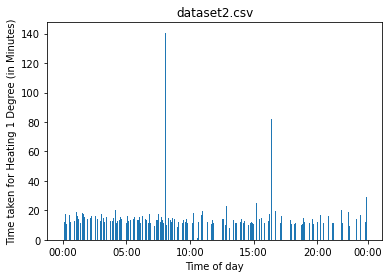

average time to Heating 2F:  23.155148245614036
Standard deviation  13.31204322453583


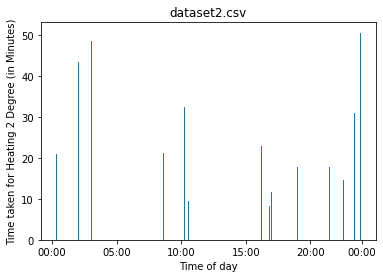

average time to Heating 3F:  34.90216666666667
Standard deviation  19.896544628558864


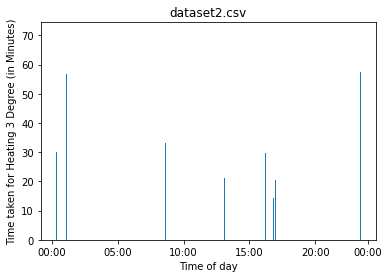

average time to Heating 4F:  42.31419666666667
Standard deviation  28.043499636005468


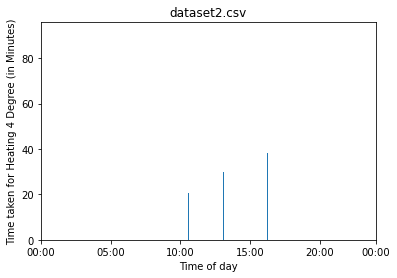

Average time to heat 1F  12.056195656883789
 standard deviation  1.6580656601501773


In [4]:
path = ''
pp = PdfPages ('./Plot' + str (n) + '.pdf')

for file_name in file_names:
    try:
      path = file_name
      dataset = pd.read_csv ((path))
    except:
      continue
    
    X = dataset.iloc[:, :]

    avg1 = time_to_change_temperature(X, 1)
    avg2 = time_to_change_temperature(X, 2)
    avg3 = time_to_change_temperature(X, 3)
    avg4 = time_to_change_temperature(X, 4)
    avg = (avg1 + avg2/2 + avg3/3 + avg4/4) / 4

    print('Average time to heat 1F ', avg)
    print(' standard deviation ', statistics.stdev([avg1, avg2/2, avg3/3, avg4/4]))

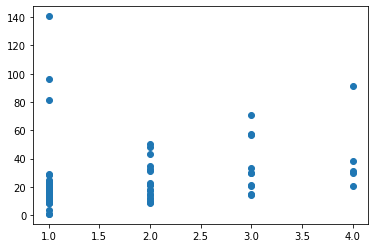

In [5]:
# pp.close ()
list = []
for arr in data:
    for elm in arr:
        list.append(elm)
df = pd.DataFrame(list)
plt.scatter(df['temp_change'], df['time'])

In [18]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(2,)),   # y = w1 * x1 + w2 * x2 + b1
    tf.keras.layers.Dense(units=1+1, input_shape=(1,)),   # y1 = w3 * x + b2   # y2 = w4 * x + b3
    tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=tf.math.softplus(t[...,1:]))),
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [19]:
def negative_log_likelihood(y_true, y_pred):

    return -y_pred.log_prob(y_true)

model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), 
    loss=negative_log_likelihood
)

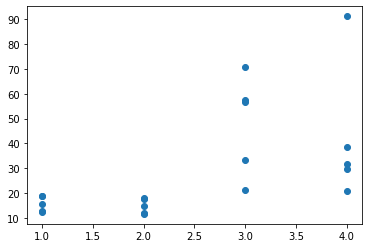

In [20]:
min_len = 10000;
for arr in data:
    if len(arr) < min_len:
        min_len = len(arr)
        
def data_generator(data):
    list = []
    for arr in data:
        list += random.sample(arr, min_len)

    df = pd.DataFrame(list)
    X = df.loc[:, ['start_temp', 'temp_change']]
    y = df['time']
    plt.scatter(df['temp_change'], df['time'])
    return X, y

X, y = data_generator(data)

Epoch 1/20
1/1 [==============================] - 0s 423ms/step - loss: 3204848475846838512563257344.0000
Epoch 2/20
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 3/20
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 4/20
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 5/20
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 6/20
1/1 [==============================] - 0s 1000us/step - loss: nan
Epoch 7/20
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 8/20
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 9/20
1/1 [==============================] - 0s 1000us/step - loss: nan
Epoch 10/20
1/1 [==============================] - 0s 999us/step - loss: nan
Epoch 11/20
1/1 [==============================] - 0s 1000us/step - loss: nan
Epoch 12/20
1/1 [==============================] - 0s 2ms/step - loss: nan
Epoch 13/20
1/1 [==============================] - 0s 1000us/step 

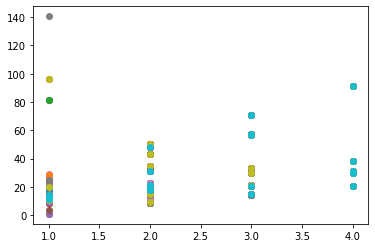

In [21]:
for i in range(100):
    X, y = data_generator(data)
    history = model2.fit(X, y, epochs=20)

In [10]:
model2.predict([[70, 5]])

array([[93.41618]], dtype=float32)

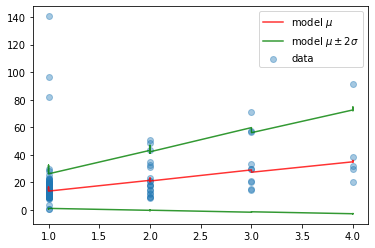

In [11]:
X = df.loc[:, ['start_temp', 'temp_change']]
y_model = model2(X.to_numpy().reshape((len(X),2)))
y_mean = y_model.mean()
y_sd = y_model.stddev()
y_mean_m2sd = y_mean - 2 * y_sd
y_mean_p2sd = y_mean + 2 * y_sd

plt.scatter(X['temp_change'], df['time'], alpha=0.4, label='data')
plt.plot(X['temp_change'], y_mean, color='red', alpha=0.8, label='model $\mu$')
plt.plot(X['temp_change'], y_mean_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
plt.plot(X['temp_change'], y_mean_p2sd, color='green', alpha=0.8)
plt.legend()
plt.show()

In [12]:
import math
from __future__ import division
 
 
def normalcdf(X):
    '''
    计算正态分布的累积分布函数(Cumulative Distribution Function，CDF)
    '''
    T=1/(1+.2316419*abs(X))
    D=0.3989423*math.exp(-X*X/2)
    Prob=D*T*(0.3193815+T*(-0.3565638+T*(1.781478+T*(-1.821256+T*1.330274))))
    if X>0:
        return 1-Prob
    else:
        return Prob
 
 
def zoneProbality(zVal,flag='0-z'):
    '''
    计算指定区间内的正态分布概率值
    '''
    if flag=='0-z':
        if zVal==0:
            return 0
        else:
            return abs(normalcdf(zVal)-0.5)
    elif flag=='inf-z':
        if zVal==0:
            return 0.5
        else:
            return normalcdf(zVal)
    elif flag=='z-inf':
        if zVal==0:
            return 0.5
        else:
            return 1-normalcdf(zVal)
    else:
        return None
 
 
def low2upProbality(L=-1.2,U=2.3):
    '''
    计算给定Z值区间的概率值
    '''
    small=zoneProbality(L,flag='inf-z')
    big=zoneProbality(U,flag='inf-z')
    return big-small
 
# print(zoneProbality(1.97,flag='0-z'))  #0.47558088818

In [13]:
m = model2(np.array([[70, 5]]))
mean = m.mean().numpy()[0][0]
std_dev = m.stddev().numpy()[0][0]
print('mean: ' + str(mean))
print('standard deviation: ' + str(std_dev))
min = y_mean_m2sd[-1].numpy()[0]
max = y_mean_p2sd[-1].numpy()[0]
print('95% from', min, 'to', max, 'min')


def calculate_probability(scope):
    probability = zoneProbality(scope / std_dev, flag='0-z') * 2
    print('prediction =', str("%.2f" % mean), 'min, ±' + str(scope), '=>', "%.2f" % (mean - scope), '~', "%.2f" % (mean + scope) + ' min,', 'probability = ' + '{:.2%}'.format(probability))
    return probability
    
res = calculate_probability(1)
res = calculate_probability(3)
res = calculate_probability(5)

if res < .6:

    for r in range(3, 100):
        res = calculate_probability(r * 2 + 1)
        if res > .6:
            break


mean: 43.715984
standard deviation: 24.017632
95% from -2.6865463 to 72.07998 min
prediction = 43.72 min, ±1 => 42.72 ~ 44.72 min, probability = 3.32%
prediction = 43.72 min, ±3 => 40.72 ~ 46.72 min, probability = 9.94%
prediction = 43.72 min, ±5 => 38.72 ~ 48.72 min, probability = 16.49%
prediction = 43.72 min, ±7 => 36.72 ~ 50.72 min, probability = 22.93%
prediction = 43.72 min, ±9 => 34.72 ~ 52.72 min, probability = 29.21%
prediction = 43.72 min, ±11 => 32.72 ~ 54.72 min, probability = 35.30%
prediction = 43.72 min, ±13 => 30.72 ~ 56.72 min, probability = 41.17%
prediction = 43.72 min, ±15 => 28.72 ~ 58.72 min, probability = 46.77%
prediction = 43.72 min, ±17 => 26.72 ~ 60.72 min, probability = 52.09%
prediction = 43.72 min, ±19 => 24.72 ~ 62.72 min, probability = 57.11%
prediction = 43.72 min, ±21 => 22.72 ~ 64.72 min, probability = 61.81%
